In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import subprocess
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
PRICES = pd.read_csv('src/data/prices_data.csv', index_col=0)
RATES = pd.read_csv('src/data/rates_data.csv', index_col=0)
COVS = pd.read_csv('src/data/covariance_data.csv', index_col=[0, 1])
CORRS = pd.read_csv('src/data/correlation_data.csv', index_col=[0, 1])

# Convert index to datetime for PRICES
PRICES.index = pd.to_datetime(PRICES.index)

# Convert index to datetime for RATES
RATES.index = pd.to_datetime(RATES.index)

# Convert index levels to datetime for COVS
COVS.index = COVS.index.set_levels(pd.to_datetime(COVS.index.levels[0]), level=0)

# Convert index levels to datetime for CORRS
CORRS.index = CORRS.index.set_levels(pd.to_datetime(CORRS.index.levels[0]), level=0)

raw_list_dates = CORRS.index.get_level_values('first') # pour l'instant. A raccourcir
raw_list_dates = list(set(PRICES.index) & set(RATES.index) & set(CORRS.index.get_level_values('first'))) # for now
raw_list_dates.sort()

In [3]:
STR_DATES_GRID_1 = ["05/07/2000", "03/07/2001", "02/07/2002", "02/07/2003", "02/07/2004", "05/07/2005"]
DATES_GRID_1 = [datetime.strptime(date_str, "%d/%m/%Y") for date_str in STR_DATES_GRID_1]
LIST_DATES_1 = [date for date in raw_list_dates if DATES_GRID_1[0] <= date <= DATES_GRID_1[-1]]
MATHS_DATES_GRID_1 = [LIST_DATES_1.index(date) / 252 for date in DATES_GRID_1]

STR_DATES_GRID_2 = ["04/01/2005", "04/01/2006", "04/01/2007", "04/01/2008", "05/01/2009", "04/01/2010"]
DATES_GRID_2 = [datetime.strptime(date_str, "%d/%m/%Y") for date_str in STR_DATES_GRID_2]
LIST_DATES_2 = [date for date in raw_list_dates if DATES_GRID_2[0] <= date <= DATES_GRID_2[-1]]
MATHS_DATES_GRID_2 = [LIST_DATES_2.index(date) / 252 for date in DATES_GRID_2]

STR_DATES_GRID_3 = ["05/01/2009", "04/01/2010", "04/01/2011", "04/01/2012", "04/01/2013", "06/01/2014"]
DATES_GRID_3 = [datetime.strptime(date_str, "%d/%m/%Y") for date_str in STR_DATES_GRID_3]
LIST_DATES_3 = [date for date in raw_list_dates if DATES_GRID_3[0] <= date <= DATES_GRID_3[-1]]
MATHS_DATES_GRID_3 = [LIST_DATES_3.index(date) / 252 for date in DATES_GRID_3]

In [4]:
def generate_json(spots, past_matrix, rates, dates, today_date, is_today_a_fixing_date, num_days_in_one_year, covar_mat, correl_mat,
                  sample_nb, rel_finite_diff_step):
    data = {
        "Currencies": [
            {"id": "eur", "InterestRate": rates[0], "Volatility": 0},
            {"id": "au_dollar", "InterestRate": rates[1], "Volatility": np.sqrt(covar_mat[4][4]), "Spot": spots[4]},
            {"id": "us_dollar", "InterestRate": rates[2], "Volatility": np.sqrt(covar_mat[5][5]), "Spot": spots[5]},
            {"id": "k_won", "InterestRate": rates[3], "Volatility": np.sqrt(covar_mat[6][6]), "Spot": spots[6]}
        ],
        "DomesticCurrencyId": "eur",
        "Assets": [
            {"CurrencyId": "eur", "Volatility": np.sqrt(covar_mat[0][0]), "Spot": spots[0]},
            {"CurrencyId": "au_dollar", "Volatility": np.sqrt(covar_mat[1][1]), "Spot": spots[1]},
            {"CurrencyId": "us_dollar", "Volatility": np.sqrt(covar_mat[2][2]), "Spot": spots[2]},
            {"CurrencyId": "k_won", "Volatility": np.sqrt(covar_mat[3][3]), "Spot": spots[3]}
        ],
        "Past": past_matrix,
        "Dates": dates,
        "TodayDate": today_date,
        "isTodayAFixingDate": is_today_a_fixing_date,
        "NumberOfDaysInOneYear": num_days_in_one_year,
        "Correlation": correl_mat,
        "SampleNb": sample_nb,
        "RelativeFiniteDifferenceStep": rel_finite_diff_step
    }
    json_data = json.dumps(data, indent=2)
    return json_data

def send_pricing_request(input_path, output_path):
    # Command to execute
    commands = f"./src/cpp/build/pricing {input_path} {output_path}"

    # Run the command using subprocess
    try:
        subprocess.run(commands, shell=True, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running the command: {e}")
    
    # call C++ code here
    return 0

def get_price_and_deltas(spots, past_matrix, rates, dates, today_date, is_today_a_fixing_date, num_days_in_one_year, covar_mat,
                         correl_mat, sample_nb, rel_finite_diff_step):
    result_json = generate_json(spots, past_matrix, rates, dates, today_date, is_today_a_fixing_date, num_days_in_one_year, covar_mat,
                                correl_mat, sample_nb, rel_finite_diff_step)

    input_path = "src/data/json_params.json"
    output_path = "src/data/results_pricing.json"
    
    with open(input_path, 'w') as json_file:
        json_file.write(result_json)

    # send_pricing_request to c++
    send_pricing_request(input_path, output_path)

    # Open output Json
    with open(output_path, 'r') as file:
        output_json = json.load(file)

    # Extract values
    price = output_json["price"]
    price_std_dev = output_json["priceStdDev"]
    delta = output_json["deltas"]
    delta_std_dev = output_json["deltasStdDev"]
    
    if is_today_a_fixing_date:
        flux = output_json["flux"]
    else:
        flux = 0
    
    return price, price_std_dev, delta, delta_std_dev, flux

In [5]:
class PortfolioManager:
    def __init__(self, selected_grid, math_grid):
        self.numberOfDaysPerYear_ = 252
        self.currentPath_ = pd.DataFrame(columns=["CAC", "ASX", "NASDAQ", "KOSPI", "AUD", "USD", "KSW"])
        self.lastPrices_ = None
        self.currentPathLine_ = 0
        self.covMatrix = None
        self.corrMatrix_ = None
        self.isTodayAFixingDate_ = True
        self.realDaysGrid_ = selected_grid
        self.mathGrid_ = math_grid
        self.hedgingPortfolio_ = Portfolio(0)
    
    def update_rates_prices_and_correl_matrix(self, current_raw_prices, covar_mat, corr_mat, dayNumber, date):
        # Update rate
        self.hedgingPortfolio_.domesticInterestRate_ = RATES.loc[date, 'REUR']
        
        # Update prices
        for i in range(1, 4):
            current_raw_prices[i] *= current_raw_prices[i+3]
            current_raw_prices[i+3] *= np.exp(RATES.loc[date, ["RAUD", "RUSD", "RKRW"][i-1]]*dayNumber/self.numberOfDaysPerYear_)
        self.lastPrices_ = current_raw_prices

        # Update cov and corr matrix
        self.covMatrix = covar_mat
        self.corrMatrix_ = corr_mat

        # Update past matrix
        self.isTodayAFixingDate_ = int(self.realDaysGrid_[self.currentPathLine_] == date)
        if self.isTodayAFixingDate_:
            self.currentPath_.loc[len(self.currentPath_)] = self.lastPrices_
            self.currentPathLine_ += 1
            
        return 0

    def rebalance_portfolio(self, dayNumber, date):
        if self.isTodayAFixingDate_:
            past_matrix = self.currentPath_.values.tolist()
        else:
            past_matrix = self.currentPath_.values.tolist() + [self.lastPrices_]

        t = dayNumber / self.numberOfDaysPerYear_
        spots = self.lastPrices_
        dates = self.mathGrid_
        rates = RATES.loc[date, :].to_list()
        today_date = dayNumber / self.numberOfDaysPerYear_
        is_today_a_fixing_date = self.isTodayAFixingDate_
        num_days_in_one_year = 252
        covar_mat = self.covMatrix
        correl_mat = self.corrMatrix_
        sample_nb = SAMPLE_NB
        rel_finite_diff_step = 0.01

        price, price_std_dev, delta, delta_std_dev, flux = get_price_and_deltas(
            spots, past_matrix, rates, dates, today_date, is_today_a_fixing_date, num_days_in_one_year, covar_mat, correl_mat, sample_nb, rel_finite_diff_step
        )
        
        self.hedgingPortfolio_.update_portfolio_composition(self.lastPrices_, delta, dayNumber, flux)
        portfolio_value = self.hedgingPortfolio_.calculate_portfolio_value(self.lastPrices_, dayNumber)

        # Append to positions as a dictionary in JSON format
        new_position = {
            "Date":date,
            "DayNumber": dayNumber,
            "Price": price,
            "PriceStdDev": price_std_dev,
            "Delta": delta,
            "DeltaStdDev": delta_std_dev,
            "PortfolioValue": portfolio_value,
            "InvestedCash": self.hedgingPortfolio_.investedCash_
        }
        self.hedgingPortfolio_.positions_.append(new_position)

class Portfolio:
    def __init__(self, initialCash):
        self.positions_ = []
        self.investedCash_ = initialCash
        self.domesticInterestRate_ = 0
        self.numberOfDaysPerYear_ = 252
        self.lastRebalancingDate_ = 0
        self.currentAssetQuantities_ = np.zeros(7)

    def get_asset_position_value(self, assetValues):
        return np.dot(self.currentAssetQuantities_, assetValues)

    def get_bond_value(self, dateToCapitalizeTo):
        day_difference = dateToCapitalizeTo - self.lastRebalancingDate_
        capitalization_factor = np.exp(self.domesticInterestRate_ * (day_difference / self.numberOfDaysPerYear_))
        return self.investedCash_ * capitalization_factor

    def calculate_portfolio_value(self, currentAssetValues, currentDate):
        return self.get_asset_position_value(currentAssetValues) + self.get_bond_value(currentDate)

    def update_portfolio_composition(self, currentAssetValues, newAssetComposition, currentDate, flux):
        share_prices_before_rebalancing = self.get_asset_position_value(currentAssetValues)
        self.currentAssetQuantities_ = newAssetComposition
        share_prices_after_rebalancing = self.get_asset_position_value(currentAssetValues)
        self.investedCash_ = self.get_bond_value(currentDate) + (share_prices_before_rebalancing - share_prices_after_rebalancing) - flux
        self.lastRebalancingDate_ = currentDate


In [12]:
def initialize_portfolio(list_grid, dates_grid, math_grid):
    portfolio_manager = PortfolioManager(dates_grid, math_grid)
    portfolio_manager.update_rates_prices_and_correl_matrix(PRICES.loc[list_grid[0], :].to_list(), COVS.loc[list_grid[0], :].values.tolist(),
                                                            CORRS.loc[list_grid[0], :].values.tolist(), 0, list_grid[0])

    t = 0
    spots = portfolio_manager.lastPrices_
    past_matrix = portfolio_manager.currentPath_.values.tolist()
    dates = math_grid
    rates = RATES.loc[list_grid[0], :].to_list()
    today_date = 0
    is_today_a_fixing_date = True
    num_days_in_one_year = 252
    covar_mat = portfolio_manager.covMatrix
    correl_mat = portfolio_manager.corrMatrix_
    sample_nb = SAMPLE_NB
    rel_finite_diff_step = 0.01
    price, price_std_dev, delta, delta_std_dev, flux = get_price_and_deltas(
        spots, past_matrix, rates, dates, today_date, is_today_a_fixing_date, num_days_in_one_year, covar_mat, correl_mat, sample_nb, rel_finite_diff_step
    )
    
    portfolio_manager.hedgingPortfolio_ = Portfolio(1000)
    portfolio_manager.hedgingPortfolio_.update_portfolio_composition(portfolio_manager.lastPrices_, delta, 0, flux)
    portfolio_value = portfolio_manager.hedgingPortfolio_.calculate_portfolio_value(portfolio_manager.lastPrices_, 0)

    # Append to positions as a dictionary in JSON format
    new_position = {
        "Date":list_grid[0],
        "DayNumber": 0,
        "Price": price,
        "PriceStdDev": price_std_dev,
        "Delta": delta,
        "DeltaStdDev": delta_std_dev,
        "PortfolioValue": portfolio_value,
        "InvestedCash": portfolio_manager.hedgingPortfolio_.investedCash_
    }
    portfolio_manager.hedgingPortfolio_.positions_.append(new_position)
    return portfolio_manager

def relacancing_calculations(list_grid, dates_grid, math_grid):
    portfolio_manager = initialize_portfolio(list_grid, dates_grid, math_grid)
    
    for index_date, date in enumerate(list_grid[1:]):
        portfolio_manager.update_rates_prices_and_correl_matrix(PRICES.loc[date, :].to_list(), COVS.loc[date, :].values.tolist(),
                                                                CORRS.loc[date, :].values.tolist(), index_date+1, date)
        portfolio_manager.rebalance_portfolio(index_date+1, date)
    
    return portfolio_manager.hedgingPortfolio_.positions_

def plot_portfolio(portfolio_compo, date_lines):
    # Create a subplot with two traces
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=('Portfolio Value and Price'))

    # Create traces for PortfolioValue and Price
    trace_portfolio_value = go.Scatter(x=portfolio_compo['Date'], y=portfolio_compo['PortfolioValue'], mode='lines', name='PortfolioValue')
    trace_price = go.Scatter(x=portfolio_compo['Date'], y=portfolio_compo['Price'], mode='lines', name='Price')

    # Add traces to the subplot
    fig.add_trace(trace_portfolio_value)
    fig.add_trace(trace_price)

    # Add vertical lines for T0 to T5
    for i, date_line in enumerate(date_lines):
        fig.add_vline(x=pd.to_datetime(date_line, format="%d/%m/%Y"), line=dict(color="red", width=2, dash='dot'))
        fig.add_annotation(x=pd.to_datetime(date_line, format="%d/%m/%Y"), y=1000, text=f'T{i}', showarrow=True)

    # Update layout for better appearance
    fig.update_layout(
        xaxis=dict(title='Date'),
        yaxis=dict(title='Values'),
        height=600,
        width=800,
        hovermode="x",
        hoverlabel=dict(bgcolor="white", font_size=12),
        showlegend=True  # Keep legend to distinguish between PortfolioValue and Price
    )
    fig.show()

In [18]:
SAMPLE_NB = 10000

,DayNumber,Price,PriceStdDev,Delta,DeltaStdDev,PortfolioValue,InvestedCash
Date,,,,,,,
2000-07-05,0,930.419216,0.119026,"[0.028820409209587297, 0.05018731843699209, 0....","[0.00011017400896334987, 0.0001126404882694346...",1000.000000,813.394341
2000-07-06,1,934.332548,0.108324,"[0.03160705986060485, 0.05355166664179825, 0.0...","[0.00011628510525313734, 0.0001321595993354836...",1004.652187,800.247339
2000-07-07,2,940.167985,0.100223,"[0.024431947867759533, 0.05952898248409435, 0....","[0.00010217317833346342, 0.0001622690784562409...",1009.570713,848.672493
2000-07-10,3,937.897513,0.099938,"[0.031085337840097062, 0.05250592977264501, 0....","[0.000114399743270296, 0.0001349011128955594, ...",1009.128129,807.028767
2000-07-11,4,934.324286,0.108792,"[0.028660045568590083, 0.051639290922465615, 0...","[0.00011083197738380877, 0.0001220652624199635...",1006.523722,820.099021
...,...,...,...,...,...,...,...
2005-06-29,1300,1005.979363,0.000530,"[0.0, 0.0, 0.0, 68.74296760667153, 0.0, 0.0, -...","[0.0, 0.0, 0.0, 1.5733492152399425e-07, 0.0, 0...",1022.823671,1022.823671
2005-06-30,1301,1006.363179,0.000461,"[0.0, 0.0, 0.0, 68.72890543023534, 0.0, 0.0, -...","[0.0, 0.0, 0.0, 1.5811989940246182e-07, 0.0, 0...",1023.209605,1023.209605
2005-07-01,1302,1006.933344,0.000375,"[0.0, 0.0, 0.0, 60.57640434034426, 0.0, 0.0, -...","[0.0, 0.0, 0.0, 0.02508943959952911, 0.0, 0.0,...",1023.786867,1023.537888


<AxesSubplot:xlabel='Date'>

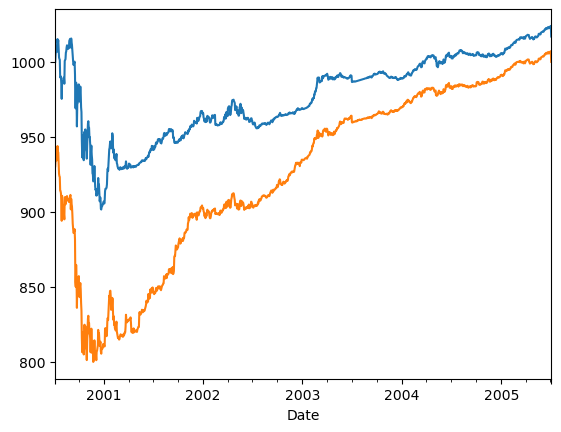

In [19]:
list_grid, dates_grid, math_grid = LIST_DATES_1, DATES_GRID_1,  MATHS_DATES_GRID_1

portfolio_compo_1 = pd.DataFrame(relacancing_calculations(list_grid, dates_grid, math_grid)).set_index("Date")
display(portfolio_compo_1)

portfolio_compo_1["PortfolioValue"].plot()
portfolio_compo_1["Price"].plot()

,DayNumber,Price,PriceStdDev,Delta,DeltaStdDev,PortfolioValue,InvestedCash
Date,,,,,,,
2005-01-04,0,1011.052912,0.097086,"[0.10965897799016583, 0.049329842969116924, 0....","[0.00018239159545451895, 3.582128254013949e-05...",1000.000000,575.594219
2005-01-05,1,1005.012404,0.097010,"[0.11166961579934229, 0.05068905527327672, 0.2...","[0.00017307873317565716, 4.706770709374104e-05...",993.716989,565.489686
2005-01-06,2,1002.683429,0.099773,"[0.09869240150649553, 0.05237835310169116, 0.2...","[0.0001806618515592662, 5.93510364944944e-05, ...",991.412198,610.336947
2005-01-07,3,1006.495040,0.097474,"[0.09569937049177489, 0.049041988483999856, 0....","[0.0001816355534056035, 3.5910151513916654e-05...",995.769190,624.158095
2005-01-10,4,1008.284092,0.096796,"[0.09815856267749958, 0.04823128691229927, 0.2...","[0.00018719358305036186, 2.638647558667392e-05...",997.766076,616.502023
...,...,...,...,...,...,...,...
2009-12-29,1300,1133.604496,0.002612,"[0.0284075885469513, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.456217512376645e-11, 0.0, 0.0, 0.0, 0.0, 0....",1295.472455,1182.978972
2009-12-30,1301,1134.029601,0.002220,"[0.02858494456587807, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3.8312495939365097e-11, 0.0, 0.0, 0.0, 0.0, 0...",1294.804030,1182.307980
2009-12-31,1302,1133.153835,0.001810,"[0.028579444604015253, 0.0, 0.0, 0.0, 0.0, 0.0...","[3.5274007453690624e-11, 0.0, 0.0, 0.0, 0.0, 0...",1294.857313,1182.359188


<AxesSubplot:xlabel='Date'>

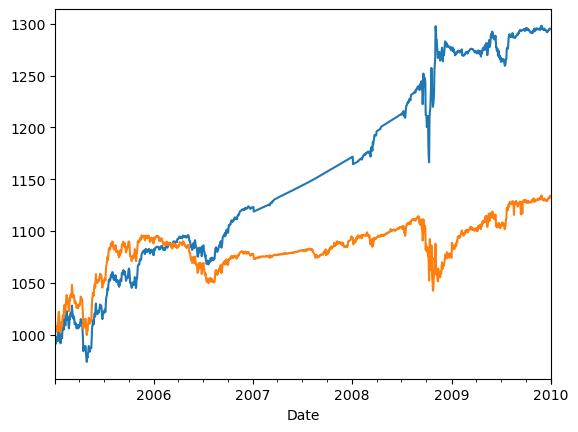

In [20]:
list_grid, dates_grid, math_grid = LIST_DATES_2, DATES_GRID_2,  MATHS_DATES_GRID_2

portfolio_compo_2 = pd.DataFrame(relacancing_calculations(list_grid, dates_grid, math_grid)).set_index("Date")
display(portfolio_compo_2)

portfolio_compo_2["PortfolioValue"].plot()
portfolio_compo_2["Price"].plot()

,DayNumber,Price,PriceStdDev,Delta,DeltaStdDev,PortfolioValue,InvestedCash
Date,,,,,,,
2009-01-05,0,964.701113,0.277437,"[0.03616108693327282, 0.07859090352340511, 0.1...","[0.000543956968956265, 0.00041951602875936965,...",1000.000000,878.628271
2009-01-06,1,976.158835,0.284842,"[0.039046728352064186, 0.07329329058929279, 0....","[0.000523497434319083, 0.00040994804738621305,...",1009.214865,876.431551
2009-01-07,2,975.445402,0.246767,"[0.0369062460673282, 0.06930934291104701, 0.11...","[0.0005636446160806466, 0.0004127100536877038,...",1010.521403,886.958705
2009-01-08,3,970.953315,0.255988,"[0.04054911921211766, 0.08044090211763961, 0.1...","[0.0005548726613665936, 0.0004491265291667933,...",1003.739452,869.048276
2009-01-09,4,962.752465,0.241564,"[0.0351635004510713, 0.07430176852080621, 0.06...","[0.0005658648584777155, 0.00038712663293567485...",996.526054,880.459037
...,...,...,...,...,...,...,...
2013-12-31,1301,1180.515433,0.000006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1268.272822,1268.272822
2014-01-01,1302,1180.527144,0.000006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1268.285404,1268.285404
2014-01-02,1303,1180.461278,0.000006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1268.297987,1268.297987


<AxesSubplot:xlabel='Date'>

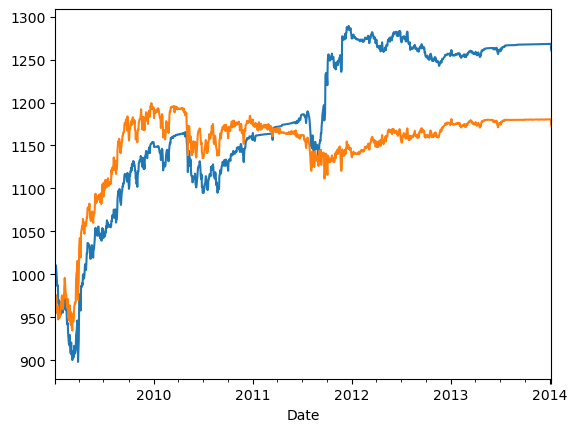

In [21]:
list_grid, dates_grid, math_grid = LIST_DATES_3, DATES_GRID_3,  MATHS_DATES_GRID_3

portfolio_compo_3 = pd.DataFrame(relacancing_calculations(list_grid, dates_grid, math_grid)).set_index("Date")
display(portfolio_compo_3)

portfolio_compo_3["PortfolioValue"].plot()
portfolio_compo_3["Price"].plot()

In [22]:
portfolio_compo_1.to_csv("src/data/precomputed_pricings_1.csv")
portfolio_compo_2.to_csv("src/data/precomputed_pricings_2.csv")
portfolio_compo_3.to_csv("src/data/precomputed_pricings_3.csv")

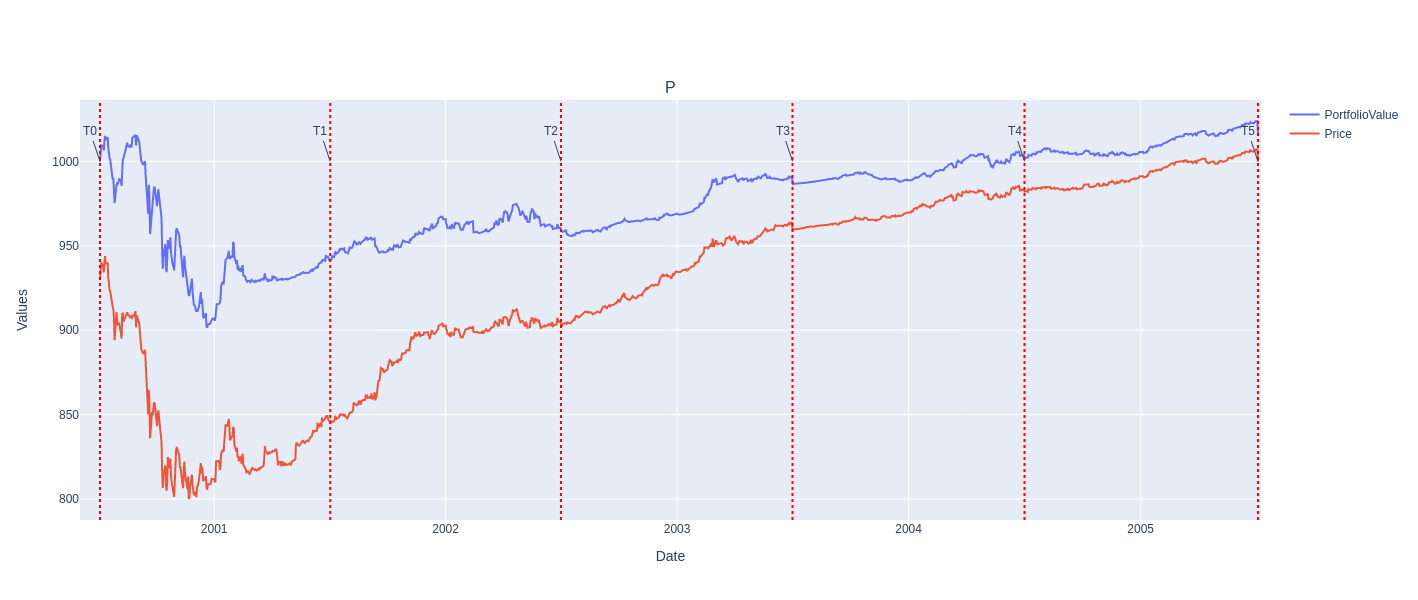

In [23]:
portfolio_compo = pd.read_csv('src/data/precomputed_pricings_1.csv', index_col=None)
date_lines = STR_DATES_GRID_1

plot_portfolio(portfolio_compo, date_lines)

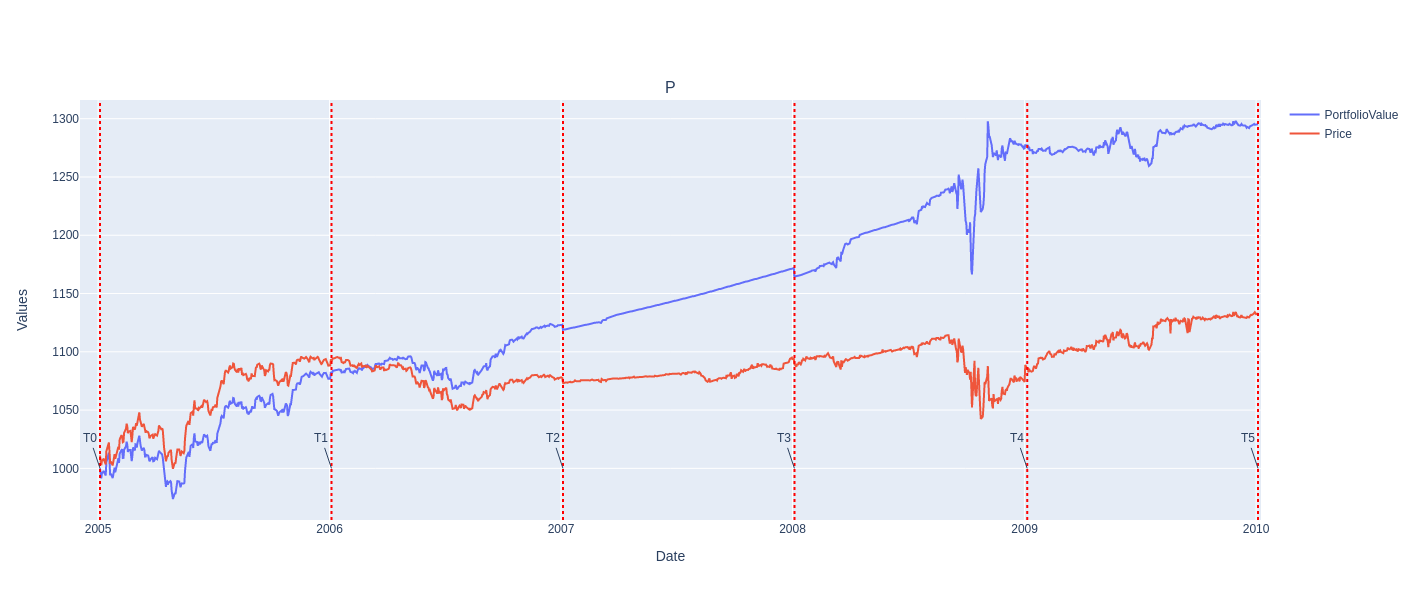

In [24]:
portfolio_compo = pd.read_csv('src/data/precomputed_pricings_2.csv', index_col=None)
date_lines = STR_DATES_GRID_2

plot_portfolio(portfolio_compo, date_lines)

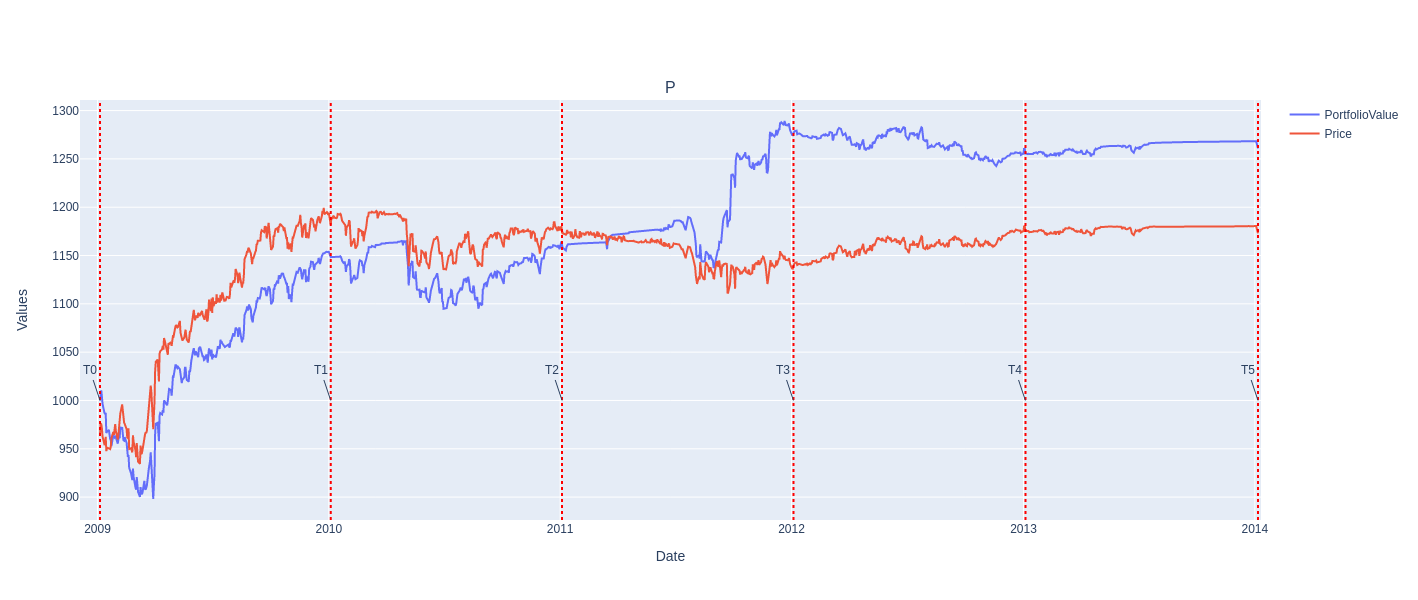

In [25]:
portfolio_compo = pd.read_csv('src/data/precomputed_pricings_3.csv', index_col=None)
date_lines = STR_DATES_GRID_3

plot_portfolio(portfolio_compo, date_lines)

<h1>Prep and tests for streamlit code</h1>

In [62]:
past_1 = []
currentPathLine_ = 0
for index_date, date in enumerate(LIST_DATES_1):
    spots = PRICES.loc[date, :].to_list()
    for i in range(1, 4):
        spots[i] *= spots[i+3]
        
    isTodayAFixingDate_ = (date == DATES_GRID_1[currentPathLine_])
    if isTodayAFixingDate_:
        past_1.append(spots)
        currentPathLine_ += 1
past_1

[[6462.7,
  2050.7023297302976,
  3830.2025396159097,
  0.7503152161382367,
  0.617588414314199,
  1.04942806170637,
  0.0009399266114701],
 [5205.78,
  2102.616998703287,
  2148.013674407632,
  0.4893779545979303,
  0.609454202522692,
  1.17882824472474,
  0.0009124057621708],
 [3735.66,
  1836.36994929006,
  977.3427991886406,
  0.5922944739963639,
  0.571703853955375,
  1.01419878296146,
  0.0008516953165615],
 [3079.07,
  1789.283564493758,
  1079.8803744798893,
  0.46282470679073034,
  0.590152565880721,
  0.866851595006935,
  0.0007302262614833],
 [3685.06,
  2047.318626734843,
  1202.167031896762,
  0.5012032954831886,
  0.579254930606282,
  0.811622433244055,
  0.0007051454676316],
 [4252.75,
  2676.3465245130956,
  1264.5651443922095,
  0.7354376965877487,
  0.622145735392881,
  0.83948959032908,
  0.0008002760632307]]

In [63]:
past_2 = []
currentPathLine_ = 0
for index_date, date in enumerate(LIST_DATES_2):
    spots = PRICES.loc[date, :].to_list()
    for i in range(1, 4):
        spots[i] *= spots[i+3]
        
    isTodayAFixingDate_ = (date == DATES_GRID_2[currentPathLine_])
    if isTodayAFixingDate_:
        past_2.append(spots)
        currentPathLine_ += 1
past_2

[[3863.3,
  2342.7939713639803,
  1184.4988696307457,
  0.5954947852007951,
  0.577241899020347,
  0.753579502637528,
  0.0007259918137163],
 [4838.52,
  2971.352473614776,
  1398.276715039578,
  1.0345348774808363,
  0.616424802110818,
  0.824538258575198,
  0.0008261078635158],
 [5574.56,
  3347.1235037835336,
  1370.4119850187262,
  1.0239754067909141,
  0.599327371397997,
  0.764350684093862,
  0.0008209996606808],
 [5446.79,
  3725.9871125279783,
  1331.8320558909315,
  1.1134131517280685,
  0.590788848945262,
  0.678288001085261,
  0.0007229673855097],
 [3359.92,
  1943.5075713025562,
  928.0505733607756,
  0.5772411340842372,
  0.527124375183769,
  0.735077918259335,
  0.0005615568512294],
 [4013.97,
  3087.657865519394,
  1309.2082437027277,
  0.8946603560921408,
  0.633196863507043,
  0.693914370966623,
  0.0006039289564548]]

In [64]:
past_3 = []
currentPathLine_ = 0
for index_date, date in enumerate(LIST_DATES_3):
    spots = PRICES.loc[date, :].to_list()
    for i in range(1, 4):
        spots[i] *= spots[i+3]
        
    isTodayAFixingDate_ = (date == DATES_GRID_3[currentPathLine_])
    if isTodayAFixingDate_:
        past_3.append(spots)
        currentPathLine_ += 1
past_3

[[3359.92,
  1943.5075713025562,
  928.0505733607756,
  0.5772411340842372,
  0.527124375183769,
  0.735077918259335,
  0.0005615568512294],
 [4013.97,
  3087.657865519394,
  1309.2082437027277,
  0.8946603560921408,
  0.633196863507043,
  0.693914370966623,
  0.0006039289564548],
 [3916.03,
  3585.131757010752,
  1692.6997970077437,
  1.203913707823221,
  0.755958198631682,
  0.751823171190136,
  0.0006688818249022],
 [3193.65,
  3354.1235857805236,
  1800.3941267387936,
  1.069684870902901,
  0.800927357032457,
  0.772797527047913,
  0.0006735499429536],
 [3730.02,
  3787.860748450294,
  2085.0156883752966,
  1.2530096422666117,
  0.801867299303589,
  0.765286599831637,
  0.0007205138680697],
 [4227.54,
  3501.9999853232544,
  2588.2131063330157,
  1.1534917259804787,
  0.657664929918544,
  0.733837234901299,
  0.0006890425769723]]

In [ ]:
fig = px.bar(df, x='continent', y='pop', color="lifeExp", text='country', 
             title="Default behavior: some text is tiny")
fig.update_traces(textposition='inside')
fig.show()

In [136]:
df = pd.DataFrame(PRICES.loc[LIST_DATES_1[0], :])
df.columns = ["positions"]
df["Deltas"] = 5
df["foreign"] = 55

df["text"] = "Foreign:<br>" + df["foreign"].astype(str) + "<br><br> Domestic:<br>" + df["positions"].astype(str)

display(df)

,positions,Deltas,foreign,text
CAC,6462.700000,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>6462.7
ASX,3320.500000,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>3320.5
NASDAQ,3649.800000,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>3649.8
KOSPI,798.270000,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>798.27
AUD,0.617588,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>0.617...
USD,1.049428,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>1.049...
KRW,0.000940,5,55,<br> Foreign:<br>55<br><br> Domestic:<br>0.000...


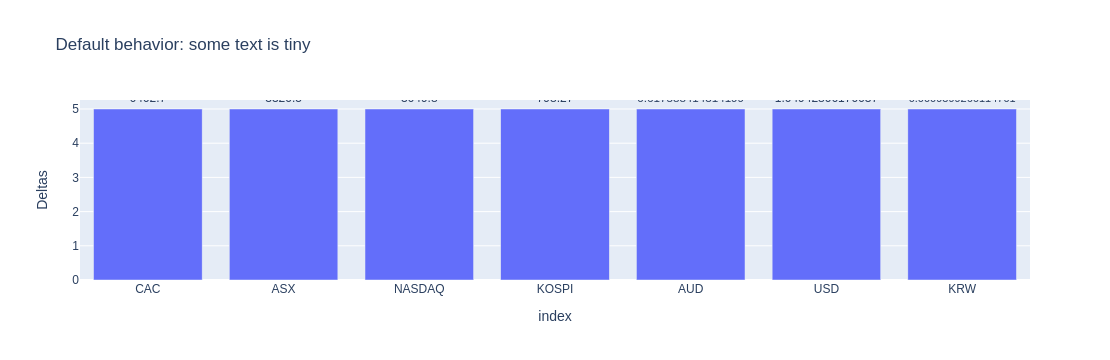

In [140]:
import plotly.express as px

fig = px.bar(df, x=df.index, y='Deltas', text='text', 
             title="Default behavior: some text is tiny")
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
[5,5,6,5] + []

[5, 5, 6, 5, 4]